In [2]:
import warnings 

warnings.simplefilter(action='ignore', category=Warning)

import os
import tempfile
import scanpy as sc
import scvi
import seaborn as sns
import torch

import anndata as ad
import pandas as pd

In [3]:
torch.set_float32_matmul_precision("high")

In [4]:
adata = ad.read_h5ad("../RData/4_chandraker_seurat_complete-dataset_clustered_res0-4_O2.h5ad")
adata

AnnData object with n_obs × n_vars = 29930 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Log10GenesPerUMI', 'mitoRatio', 'riboRatio', 'barcode', 'patient_id', 'condition', 'TCR_clones', 'TCR_proportion', 'TCR_CDR3nt', 'TCR_CDR3aa', 'TCR_v_gene', 'TCR_d_gene', 'TCR_j_gene', 'TCR_chain', 'TCR_cellranger_clonotype_id', 'TCR_clonotype_id', 'BCR_clones', 'BCR_proportion', 'BCR_CDR3nt', 'BCR_CDR3aa', 'BCR_v_gene', 'BCR_d_gene', 'BCR_j_gene', 'BCR_chain', 'BCR_cellranger_clonotype_id', 'BCR_clonotype_id', 'repseq', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'SCT_snn_res.0.6', 'SCT_snn_res.0.8', 'seurat_clusters', 'study_clusters', 'cluster_name'
    var: 'names'
    obsm: 'X_harmony', 'X_integrated_dr', 'X_pca', 'X_ref.umap', 'X_umap'
    layers: 'counts_RNA'

In [5]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts_RNA",
    categorical_covariate_keys=["patient_id",
                                     "condition"],
)

In [6]:
model = scvi.model.SCVI(adata)

In [7]:
model.train(accelerator="gpu",
    devices=[0]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 267/267: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [1:48:15<00:00, 25.37s/it, v_num=1, train_loss_step=4.57e+3, train_loss_epoch=4.49e+3]

`Trainer.fit` stopped: `max_epochs=267` reached.


Epoch 267/267: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [1:48:15<00:00, 24.33s/it, v_num=1, train_loss_step=4.57e+3, train_loss_epoch=4.49e+3]


In [8]:
model_key = "scvi_model"
model_dir = os.path.join("models", model_key)
model.save(model_dir, overwrite=True)

In [9]:
SCVI_LATENT_KEY = "X_" + model_key

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, 
                key_added=model_key)

In [10]:
sc.tl.umap(adata,
           neighbors_key=model_key)

In [11]:
adata

AnnData object with n_obs × n_vars = 29930 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Log10GenesPerUMI', 'mitoRatio', 'riboRatio', 'barcode', 'patient_id', 'condition', 'TCR_clones', 'TCR_proportion', 'TCR_CDR3nt', 'TCR_CDR3aa', 'TCR_v_gene', 'TCR_d_gene', 'TCR_j_gene', 'TCR_chain', 'TCR_cellranger_clonotype_id', 'TCR_clonotype_id', 'BCR_clones', 'BCR_proportion', 'BCR_CDR3nt', 'BCR_CDR3aa', 'BCR_v_gene', 'BCR_d_gene', 'BCR_j_gene', 'BCR_chain', 'BCR_cellranger_clonotype_id', 'BCR_clonotype_id', 'repseq', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'SCT_snn_res.0.6', 'SCT_snn_res.0.8', 'seurat_clusters', 'study_clusters', 'cluster_name', '_scvi_batch', '_scvi_labels'
    var: 'names'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'scvi_model', 'umap'
    obsm: 'X_harmony', '

In [12]:
SCVI_LATENT_KEY

'X_scvi_model'

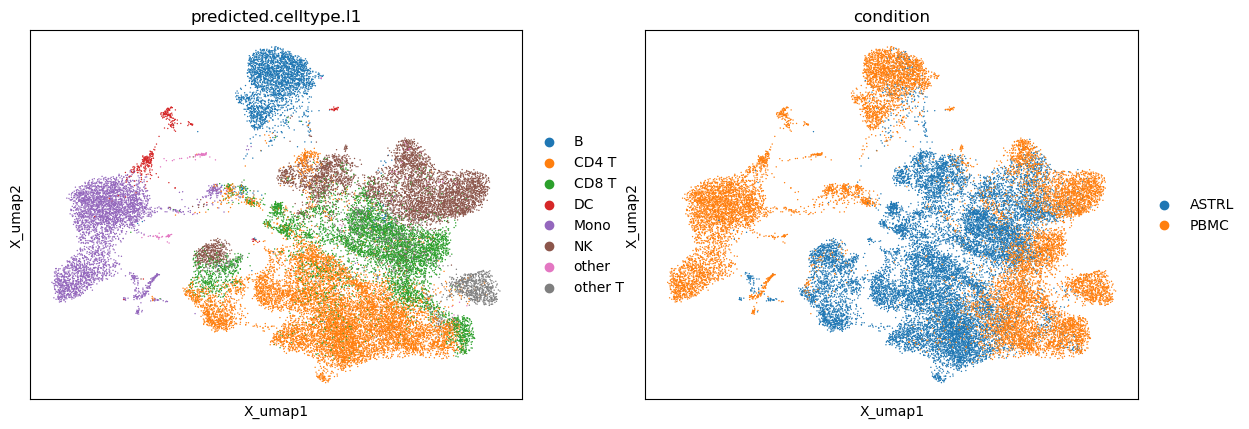

In [13]:
sc.pl.embedding(
    adata, basis="X_umap",
    color=["predicted.celltype.l1", "condition"],
    
)

In [20]:
for res in [0.2, 0.5, 1.0]:
    SCVI_CLUSTERS_KEY = "leiden_" + str(res) + model_key
    sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, 
                 resolution=res, neighbors_key=model_key)

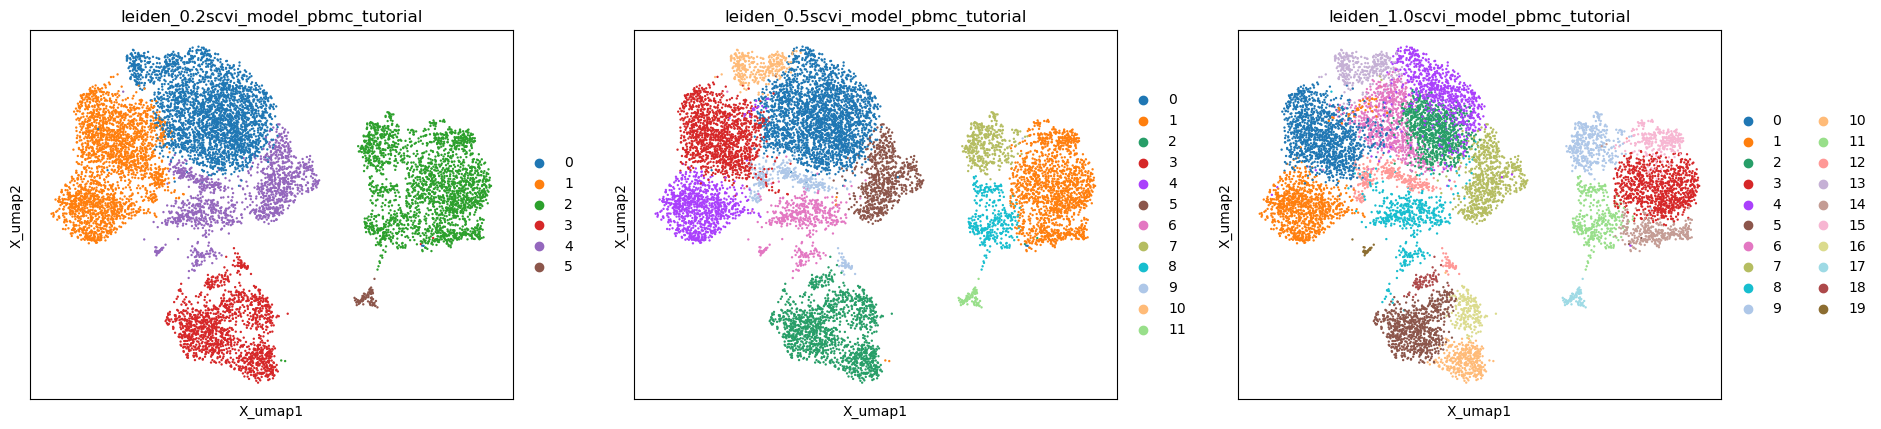

In [23]:
sc.pl.embedding(
    adata, basis="X_umap",
    color=["leiden_" + str(res) + model_key for res in [0.2, 0.5, 1.0]],
    
)